In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.lines import Line2D
import os


In [2]:
# Load the first dataset for growth data
file_path_growth = '/Users/noahbucher/Documents_local/Plant_reconstruction/ppheno/data/GT_growth/plant-db_730-826.csv'
gt_data = pd.read_csv(file_path_growth, delimiter=';')

# Clean and process growth data
gt_data = gt_data.dropna(axis=1, how='all')  # Remove columns with only NaN values
gt_data['date'] = pd.to_datetime(gt_data['date'], format='%d.%m.%y')
gt_data['height'] = pd.to_numeric(gt_data['height'], errors='coerce')
gt_data['width'] = pd.to_numeric(gt_data['width'], errors='coerce')
gt_data['leaf_count'] = pd.to_numeric(gt_data['leaf_count'], errors='coerce')
gt_data['flower_count'] = pd.to_numeric(gt_data['flower_count'], errors='coerce')

# print("Growth data columns:")
# print(gt_data.columns)

# load csv file with volumetric growth data
file_path = '/Users/noahbucher/Documents_local/Plant_reconstruction/ppheno/data/figures/volumes.csv'
calc_data = pd.read_csv(file_path, delimiter=',')
calc_data['date'] = pd.to_datetime(calc_data['date'])
calc_data['volume'] = pd.to_numeric(calc_data['volume'], errors='coerce')
calc_data['volume (cm^3)'] = calc_data['volume'] * 1000000
calc_data['height'] = pd.to_numeric(calc_data['height'], errors='coerce')
calc_data['height'] = calc_data['height'] * 100
calc_data['max_width'] = pd.to_numeric(calc_data['max_width'], errors='coerce')
calc_data['width'] = calc_data['max_width'] * 100
calc_data[['row', 'plant_number']] = calc_data['code'].str.split('-', expand=True)
calc_data['plant_number'] = pd.to_numeric(calc_data['plant_number'], errors='coerce')


# print("Volume data columns:")
# print(calc_data.columns)

# add "days" field for better plotting
start_date = pd.to_datetime('2024-07-30')
# Add a 'days' column to gt_data
gt_data['days'] = (gt_data['date'] - start_date).dt.days
calc_data['days'] = (calc_data['date'] - start_date).dt.days



# Filter gt_data by Row 'C' and Plant_Number 3
filtered_data = gt_data[(gt_data['row'] == 'C') & (gt_data['plant_number'] == 3)]

# Select only the 'Height' and 'Date' columns
Plant_C_3 = filtered_data[['date', 'height', 'leaf_count' , 'width', 'flower_count']]

# Print the filtered data
# print(filtered_data)

# print("gt_data head: ")
# print(gt_data.head())

# print("calc_data head: ")  
# print(calc_data.head())

num_rows = len(calc_data)
print(f"Number of rows: {num_rows}")

Number of rows: 109


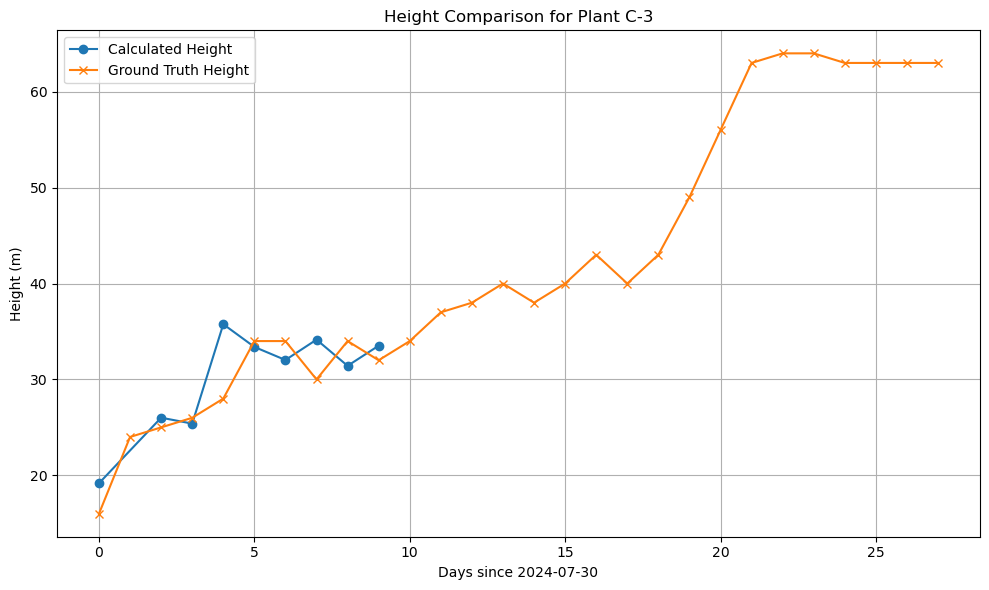

In [3]:
def compare_heights_per_plant(row, plant_number):
    # Filter calc_data by row and plant_number
    filtered_calc_data = calc_data[(calc_data['row'] == row) & (calc_data['plant_number'] == plant_number)]

    # Filter gt_data by row and plant_number
    filtered_gt_data = gt_data[(gt_data['row'] == row) & (gt_data['plant_number'] == plant_number)]

    # Plot the calculated height
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_calc_data['days'], filtered_calc_data['width'], label='Calculated Height', marker='o')

    # Plot the ground truth height
    plt.plot(filtered_gt_data['days'], filtered_gt_data['width'], label='Ground Truth Height', marker='x')

    # Customize the plot
    plt.title(f'Height Comparison for Plant {row}-{plant_number}')
    plt.xlabel('Days since 2024-07-30')
    plt.ylabel('Height (m)')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example: Compare heights for plant in row 'C' and plant number 3
compare_heights_per_plant('C', 3)


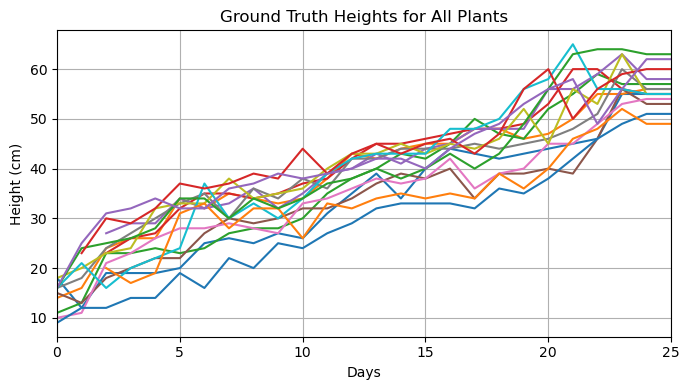

In [75]:
plt.figure(figsize=(7, 4))

# Group the data by 'row' and 'plant_number' to plot each plant's height
for (row, plant_number), plant_data in gt_data.groupby(['row', 'plant_number']):
    plt.plot(plant_data['days'], plant_data['width'], label=f'Plant {row}-{plant_number}')

# Customize the plot
plt.title('Ground Truth Heights for All Plants')
plt.xlabel('Days')
plt.ylabel('Height (cm)')
plt.xlim(0, 25)  # Example: Show days from 0 to 30 (change to desired range)

# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside the plot
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
# merge data along days, row and plant_number
merged_data = pd.merge(gt_data, calc_data, on=['date','days', 'row', 'plant_number'], how='inner')

# Rename the columns using the rename() function
merged_data = merged_data.rename(columns={
    'height_x': 'height_gt',
    'height_y': 'height_calc',
    'width_x': 'width_gt',
    'width_y': 'width_calc'
})

# Print the updated columns to verify
print(merged_data.columns)

Index(['date', 'row', 'plant_number', 'height_gt', 'leaf_count', 'width_gt',
       'flower_count', 'days', 'code', 'volume', 'height_calc', 'max_width',
       'volume (cm^3)', 'width_calc'],
      dtype='object')


In [47]:
# Ensure that 'height_gt' and 'height_calc' are numeric
merged_data['height_gt'] = pd.to_numeric(merged_data['height_gt'], errors='coerce')
merged_data['height_calc'] = pd.to_numeric(merged_data['height_calc'], errors='coerce')

# Drop any rows with missing values in 'height_gt' or 'height_calc'
merged_data = merged_data.dropna(subset=['height_gt', 'height_calc'])

# Calculate the residuals (errors between calculated and ground truth heights)
residuals = merged_data['height_calc'] - merged_data['height_gt']

# Calculate the standard deviation of residuals
residual_std = residuals.std()

# 1. Unfiltered data metrics
mae_unfiltered = residuals.abs().mean()

ss_res_unfiltered = (residuals ** 2).sum()  # Sum of squares of residuals
ss_tot_unfiltered = ((merged_data['height_gt'] - merged_data['height_gt'].mean()) ** 2).sum()  # Total sum of squares
r2_unfiltered = 1 - (ss_res_unfiltered / ss_tot_unfiltered) if ss_tot_unfiltered != 0 else float('nan')

mape_unfiltered = (residuals.abs() / merged_data['height_gt']).mean() * 100

# Filter the data by 2 * residual standard deviation
filtered_data = merged_data[residuals.abs() <= 2 * residual_std]

# Recalculate the residuals for the filtered data
filtered_residuals = filtered_data['height_calc'] - filtered_data['height_gt']

# 2. Filtered data metrics
mae_filtered = filtered_residuals.abs().mean()

ss_res_filtered = (filtered_residuals ** 2).sum()  # Sum of squares of residuals
ss_tot_filtered = ((filtered_data['height_gt'] - filtered_data['height_gt'].mean()) ** 2).sum()  # Total sum of squares
r2_filtered = 1 - (ss_res_filtered / ss_tot_filtered) if ss_tot_filtered != 0 else float('nan')

mape_filtered = (filtered_residuals.abs() / filtered_data['height_gt']).mean() * 100

# Print the metrics for unfiltered data
print("Metrics for the unfiltered data:")
print(f"Mean Absolute Error (MAE): {mae_unfiltered:.4f} cm")
print(f"R² (Coefficient of Determination): {r2_unfiltered:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_unfiltered:.2f}%")
print(f"Number of rows: {len(merged_data)}")

# Print the metrics for filtered data
print("\nMetrics for the filtered data (2 * residual std filtering):")
print(f"Mean Absolute Error (MAE): {mae_filtered:.4f} cm")
print(f"R² (Coefficient of Determination): {r2_filtered:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_filtered:.2f}%")
print(f"Number of rows after filtering: {len(filtered_data)}")

# Return metrics in a dictionary
metrics = {
    'unfiltered': {
        'MAE': mae_unfiltered,
        'R2': r2_unfiltered,
        'MAPE': mape_unfiltered,
        'num_rows': len(merged_data)
    },
    'filtered': {
        'MAE': mae_filtered,
        'R2': r2_filtered,
        'MAPE': mape_filtered,
        'num_rows': len(filtered_data)
    }
}

# Output the metrics dictionary
print("\nReturned metrics dictionary:")
print(metrics)


Metrics for the unfiltered data:
Mean Absolute Error (MAE): 1.7995 cm
R² (Coefficient of Determination): 0.9629
Mean Absolute Percentage Error (MAPE): 8.55%
Number of rows: 107

Metrics for the filtered data (2 * residual std filtering):
Mean Absolute Error (MAE): 1.0918 cm
R² (Coefficient of Determination): 0.9926
Mean Absolute Percentage Error (MAPE): 6.26%
Number of rows after filtering: 97

Returned metrics dictionary:
{'unfiltered': {'MAE': 1.7994751401869158, 'R2': 0.9629264220885168, 'MAPE': 8.55033217190163, 'num_rows': 107}, 'filtered': {'MAE': 1.091829793814433, 'R2': 0.9925802739424092, 'MAPE': 6.256113574073894, 'num_rows': 97}}


In [41]:
# Ensure that 'width_gt' and 'width_calc' are numeric
merged_data['width_gt'] = pd.to_numeric(merged_data['width_gt'], errors='coerce')
merged_data['width_calc'] = pd.to_numeric(merged_data['width_calc'], errors='coerce')

# Drop any rows with missing values in 'width_gt' or 'width_calc'
merged_data_width = merged_data.dropna(subset=['width_gt', 'width_calc'])

# Calculate the residuals (errors between calculated and ground truth widths)
residuals_width = merged_data_width['width_calc'] - merged_data_width['width_gt']

# 1. Mean Absolute Error (MAE)
mae_width = residuals_width.abs().mean()

# 2. R² (Coefficient of Determination)
ss_res_width = (residuals_width ** 2).sum()  # Sum of squares of residuals
ss_tot_width = ((merged_data_width['width_gt'] - merged_data_width['width_gt'].mean()) ** 2).sum()  # Total sum of squares
r2_width = 1 - (ss_res_width / ss_tot_width) if ss_tot_width != 0 else float('nan')

# 3. Mean Absolute Percentage Error (MAPE)
mape_width = (residuals_width.abs() / merged_data_width['width_gt']).mean() * 100

# # Remove outliers where residuals are greater than 2 standard deviations
# threshold = 2 * residuals_width.std()
# merged_data_width = merged_data_width[residuals_width.abs() <= threshold]

# Recalculate residuals and metrics
residuals_width_filtered = merged_data_width['width_calc'] - merged_data_width['width_gt']
mae_width_filtered = residuals_width_filtered.abs().mean()
ss_res_width_filtered = (residuals_width_filtered ** 2).sum()
ss_tot_width_filtered = ((merged_data_width['width_gt'] - merged_data_width['width_gt'].mean()) ** 2).sum()
r2_width_filtered = 1 - (ss_res_width_filtered / ss_tot_width_filtered) if ss_tot_width_filtered != 0 else float('nan')
mape_width_filtered = (residuals_width_filtered.abs() / merged_data_width['width_gt']).mean() * 100

# Print the metrics
print("Width Metrics for the merged data:")
print(f"Mean Absolute Error (MAE): {mae_width_filtered:.4f} cm")
print(f"R² (Coefficient of Determination): {r2_width_filtered:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_width_filtered:.2f}%")
# print(f"Sum of Squares of Residuals (SS_res): {ss_res_width}")
# print(f"Total Sum of Squares (SS_tot): {ss_tot_width}")

# std_width_gt = merged_data_width['width_gt'].std()
# print(f"Standard Deviation of Ground Truth Widths: {std_width_gt:.4f} cm")

num_rows = len(merged_data_width)
print(f"Number of rows: {num_rows}")

Width Metrics for the merged data:
Mean Absolute Error (MAE): 2.5863 cm
R² (Coefficient of Determination): 0.7202
Mean Absolute Percentage Error (MAPE): 10.26%
Number of rows: 107


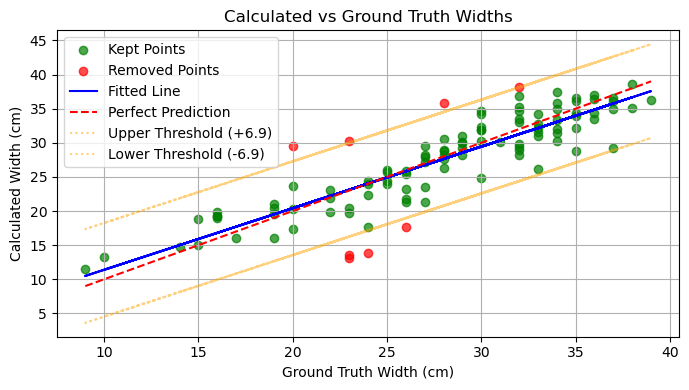

Plot saved as: /Users/noahbucher/Documents/Uni/Master Thesis/Writing/graphs/results/Calculated_vs_Ground_Truth_Widths.png


In [58]:
# Fit a line to the points using numpy's polyfit function
slope, intercept = np.polyfit(merged_data['width_gt'], merged_data['width_calc'], 1)

# Generate the fitted line values
line_fit = slope * merged_data['width_gt'] + intercept

# Calculate residuals (difference between actual and predicted values)
residuals_width = merged_data['width_calc'] - line_fit

# Set a threshold for filtering based on residuals (2 * standard deviation)
threshold = 2 * residuals_width.std()

# Filter data for points within the threshold (points to keep)
merged_data_filtered = merged_data[residuals_width.abs() <= threshold]

# Points that will be removed (residuals outside the threshold)
merged_data_removed = merged_data[residuals_width.abs() > threshold]

# Create the plot
plt.figure(figsize=(7, 4))

# Scatter plot of points to keep (in green)
plt.scatter(merged_data_filtered['width_gt'], merged_data_filtered['width_calc'], alpha=0.7, color='green', label='Kept Points')

# Scatter plot of points to be removed (in red)
plt.scatter(merged_data_removed['width_gt'], merged_data_removed['width_calc'], alpha=0.7, color='red', label='Removed Points')

# Plot the line of best fit
plt.plot(merged_data['width_gt'], line_fit, color='blue', label='Fitted Line')

# Plot the perfect prediction line (y = x)
plt.plot(
    [merged_data['width_gt'].min(), merged_data['width_gt'].max()],
    [merged_data['width_gt'].min(), merged_data['width_gt'].max()],
    color='red', linestyle='--', label='Perfect Prediction'
)

# Add threshold lines (above and below the fitted line)
plt.plot(merged_data['width_gt'], line_fit + threshold, color='orange', linestyle=':', label=f'Upper Threshold (+{threshold:.1f})', alpha=0.5)
plt.plot(merged_data['width_gt'], line_fit - threshold, color='orange', linestyle=':', label=f'Lower Threshold (-{threshold:.1f})', alpha=0.5)

# Add title and labels
plt.title('Calculated vs Ground Truth Widths')
plt.xlabel('Ground Truth Width (cm)')
plt.ylabel('Calculated Width (cm)')
plt.legend()
plt.grid(True)

# Adjust layout to avoid cut-offs
plt.tight_layout()

# Define the folder where you want to save the plot
save_folder = '/Users/noahbucher/Documents/Uni/Master Thesis/Writing/graphs/results/'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Generate the file name from the plot title
file_name = plt.gca().get_title().replace(' ', '_').replace(':', '').replace('/', '') + '.png'

# Combine the folder path and the file name
save_path = os.path.join(save_folder, file_name)

# Save the plot with bbox_inches='tight' to avoid cutting off any part of the plot
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print(f'Plot saved as: {save_path}')


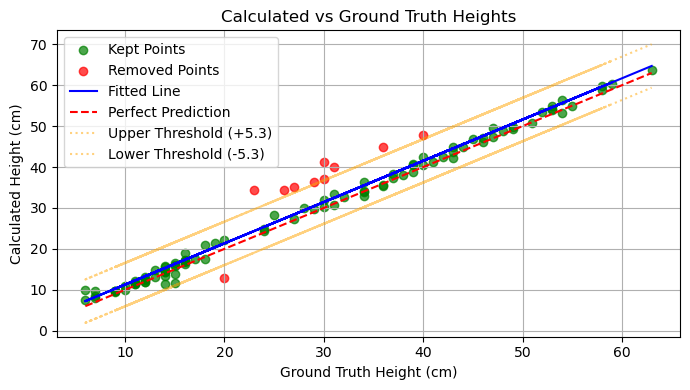

Plot saved as: /Users/noahbucher/Documents/Uni/Master Thesis/Writing/graphs/results/Calculated_vs_Ground_Truth_Heights.png


In [57]:
# Fit a line to the points using numpy's polyfit function
slope, intercept = np.polyfit(merged_data['height_gt'], merged_data['height_calc'], 1)

# Generate the fitted line values
line_fit = slope * merged_data['height_gt'] + intercept

# Calculate residuals (difference between actual and predicted values)
residuals_height = merged_data['height_calc'] - line_fit

# Set a threshold for filtering based on residuals (2 * standard deviation)
threshold = 2 * residuals_height.std()

# Filter data for points within the threshold (points to keep)
merged_data_filtered = merged_data[residuals_height.abs() <= threshold]

# Points that will be removed (residuals outside the threshold)
merged_data_removed = merged_data[residuals_height.abs() > threshold]

# Create the plot
plt.figure(figsize=(7, 4))

# Scatter plot of points to keep (in green)
plt.scatter(merged_data_filtered['height_gt'], merged_data_filtered['height_calc'], alpha=0.7, color='green', label='Kept Points')

# Scatter plot of points to be removed (in red)
plt.scatter(merged_data_removed['height_gt'], merged_data_removed['height_calc'], alpha=0.7, color='red', label='Removed Points')

# Plot the line of best fit
plt.plot(merged_data['height_gt'], line_fit, color='blue', label='Fitted Line')

# Plot the perfect prediction line (y = x)
plt.plot(
    [merged_data['height_gt'].min(), merged_data['height_gt'].max()],
    [merged_data['height_gt'].min(), merged_data['height_gt'].max()],
    color='red', linestyle='--', label='Perfect Prediction'
)

# Add threshold lines (above and below the fitted line)
plt.plot(merged_data['height_gt'], line_fit + threshold, color='orange', linestyle=':', label=f'Upper Threshold (+{threshold:.1f})', alpha=0.5)
plt.plot(merged_data['height_gt'], line_fit - threshold, color='orange', linestyle=':', label=f'Lower Threshold (-{threshold:.1f})', alpha=0.5)

# Add title and labels
plt.title('Calculated vs Ground Truth Heights')
plt.xlabel('Ground Truth Height (cm)')
plt.ylabel('Calculated Height (cm)')
plt.legend()
plt.grid(True)

# Adjust layout to avoid cut-offs
plt.tight_layout()

# Define the folder where you want to save the plot
save_folder = '/Users/noahbucher/Documents/Uni/Master Thesis/Writing/graphs/results/'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Generate the file name from the plot title
file_name = plt.gca().get_title().replace(' ', '_').replace(':', '').replace('/', '') + '.png'

# Combine the folder path and the file name
save_path = os.path.join(save_folder, file_name)

# Save the plot with bbox_inches='tight' to avoid cutting off any part of the plot
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print(f'Plot saved as: {save_path}')


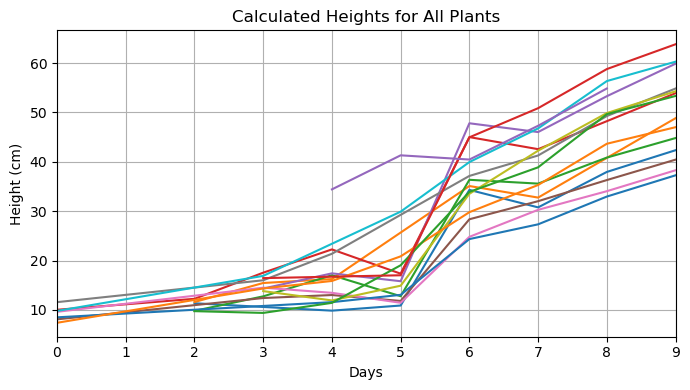

In [73]:
plt.figure(figsize=(7, 4))

# Group the data by 'row' and 'plant_number' to plot each plant's calculated height
for (row, plant_number), plant_data in merged_data.groupby(['row', 'plant_number']):
    plt.plot(plant_data['days'], plant_data['height_calc'], label=f'Plant {row}-{plant_number}')

# Customize the plot
plt.title('Calculated Heights for All Plants')
plt.xlabel('Days')
plt.ylabel('Height (cm)')
plt.xlim(0, 9)  # Adjust the range of days as needed

# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Uncomment this to move the legend outside the plot
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


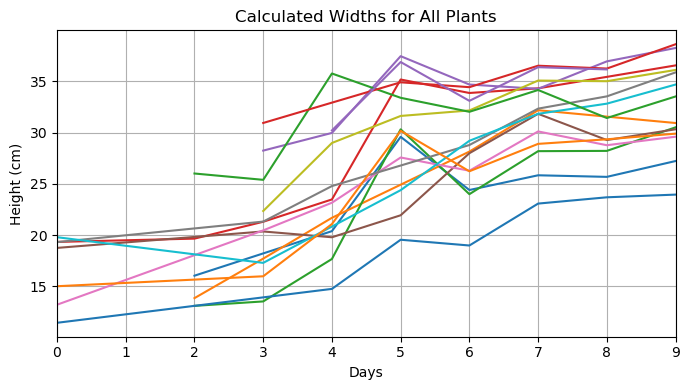

In [76]:
plt.figure(figsize=(7, 4))

# Group the data by 'row' and 'plant_number' to plot each plant's calculated height
for (row, plant_number), plant_data in merged_data.groupby(['row', 'plant_number']):
    plt.plot(plant_data['days'], plant_data['width_calc'], label=f'Plant {row}-{plant_number}')

# Customize the plot
plt.title('Calculated Widths for All Plants')
plt.xlabel('Days')
plt.ylabel('Height (cm)')
plt.xlim(0, 9)  # Adjust the range of days as needed

# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Uncomment this to move the legend outside the plot
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [60]:
# Sort the DataFrame by 'width_calc' in descending order and get the top 3 rows
top_3_plants = merged_data.sort_values(by='width_calc', ascending=False).tail(5)

# Extract details for the widest, second widest, and third widest
for i, plant in enumerate(top_3_plants.itertuples(), start=1):
    print(f"{i} widest plant: Row {plant.row}-{plant.plant_number} on date {plant.date} with a width of {plant.width_calc:.2f} cm")


1 widest plant: Row A-2 on date 2024-08-01 00:00:00 with a width of 13.87 cm
2 widest plant: Row A-3 on date 2024-08-02 00:00:00 with a width of 13.54 cm
3 widest plant: Row B-2 on date 2024-07-30 00:00:00 with a width of 13.22 cm
4 widest plant: Row A-3 on date 2024-08-01 00:00:00 with a width of 13.11 cm
5 widest plant: Row C-1 on date 2024-07-30 00:00:00 with a width of 11.46 cm


In [61]:
# Check if 'width_gt' has missing values and handle them before normalization
print(merged_data['width_gt'].isnull().sum())  # Check for missing values

# Drop rows where 'width_gt' is NaN, if any
merged_data = merged_data.dropna(subset=['width_gt'])

# Ensure that 'volume (cm^3)', 'height_gt', and 'width_gt' are numeric
merged_data['volume (cm^3)'] = pd.to_numeric(merged_data['volume (cm^3)'], errors='coerce')
merged_data['height_gt'] = pd.to_numeric(merged_data['height_gt'], errors='coerce')
merged_data['width_gt'] = pd.to_numeric(merged_data['width_gt'], errors='coerce')

# Min-Max normalization for 'volume_calc'
merged_data['normalized_volume_calc'] = (merged_data['volume (cm^3)'] - merged_data['volume (cm^3)'].min()) / (merged_data['volume (cm^3)'].max() - merged_data['volume (cm^3)'].min())

# Min-Max normalization for 'height_gt'
merged_data['normalized_height_gt'] = (merged_data['height_gt'] - merged_data['height_gt'].min()) / (merged_data['height_gt'].max() - merged_data['height_gt'].min())

# Min-Max normalization for 'width_gt'
merged_data['normalized_width_gt'] = (merged_data['width_gt'] - merged_data['width_gt'].min()) / (merged_data['width_gt'].max() - merged_data['width_gt'].min())

# Print the first few rows to verify
print(merged_data[['volume (cm^3)', 'height_gt', 'width_gt', 'normalized_volume_calc', 'normalized_height_gt', 'normalized_width_gt']].head())


0
   volume (cm^3)  height_gt  width_gt  normalized_volume_calc  \
0          163.5        6.0      16.0                0.076718   
1           89.6        7.0      15.0                0.031936   
2           74.4        9.0      10.0                0.022725   
3          106.7       15.0      16.0                0.042298   
4          188.1        7.0      16.0                0.091625   

   normalized_height_gt  normalized_width_gt  
0              0.000000             0.233333  
1              0.017544             0.200000  
2              0.052632             0.033333  
3              0.157895             0.233333  
4              0.017544             0.233333  


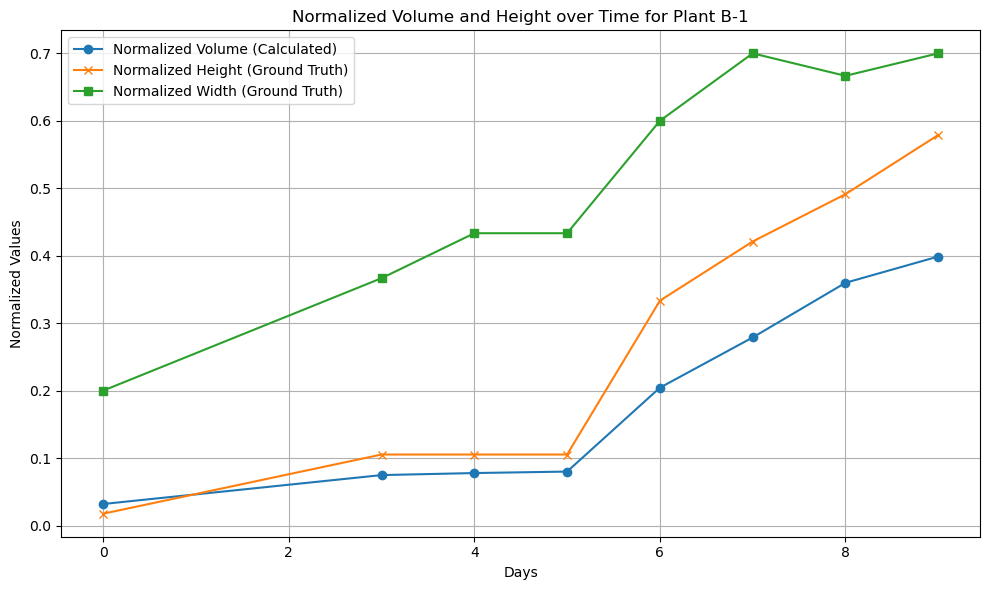

In [62]:
import matplotlib.pyplot as plt

def plot_normalized_data_for_plant(row, plant_number):
    # Filter the data for the specified plant
    plant_data = merged_data[(merged_data['row'] == row) & (merged_data['plant_number'] == plant_number)]

    # Check if there is any data for the plant
    if plant_data.empty:
        print(f"No data found for Plant {row}-{plant_number}.")
        return

    # Plot normalized_volume_calc
    plt.figure(figsize=(10, 6))
    plt.plot(plant_data['days'], plant_data['normalized_volume_calc'], label='Normalized Volume (Calculated)', marker='o')

    # Plot normalized_height_gt
    plt.plot(plant_data['days'], plant_data['normalized_height_gt'], label='Normalized Height (Ground Truth)', marker='x')

    # Plot normalized_width_gt
    plt.plot(plant_data['days'], plant_data['normalized_width_gt'], label='Normalized Width (Ground Truth)', marker='s')
    # Customize the plot
    plt.title(f'Normalized Volume and Height over Time for Plant {row}-{plant_number}')
    plt.xlabel('Days')
    plt.ylabel('Normalized Values')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example: Call the function to plot for a specific plant (row 'A', plant number 1)
plot_normalized_data_for_plant('B', 1)


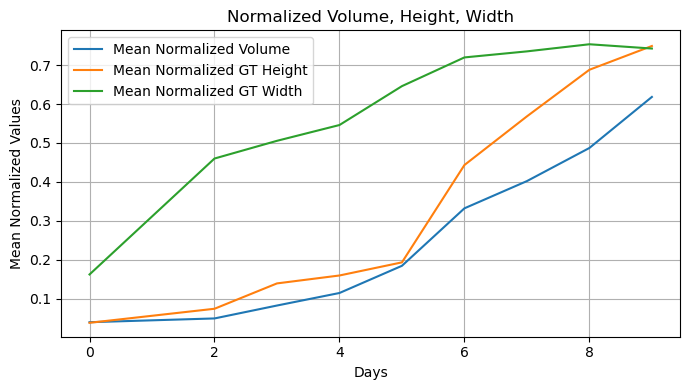

In [78]:
import matplotlib.pyplot as plt

def plot_mean_normalized_volume_vs_growth():
    # Ensure 'normalized_volume_calc' and 'normalized_height_gt' are numeric
    merged_data['normalized_volume_calc'] = pd.to_numeric(merged_data['normalized_volume_calc'], errors='coerce')
    merged_data['normalized_height_gt'] = pd.to_numeric(merged_data['normalized_height_gt'], errors='coerce')
    merged_data['normalized_width_gt'] = pd.to_numeric(merged_data['normalized_width_gt'], errors='coerce')

    # Group the data by 'days' and calculate the mean of 'normalized_volume_calc' and 'normalized_height_gt'
    averaged_data = merged_data.groupby('days').agg(
        mean_normalized_volume=('normalized_volume_calc', 'mean'),
        mean_normalized_height=('normalized_height_gt', 'mean'),
        mean_normalized_width=('normalized_width_gt', 'mean')
    ).reset_index()

    # Plot the mean normalized volume over time
    plt.figure(figsize=(7, 4))
    plt.plot(averaged_data['days'], averaged_data['mean_normalized_volume'], label='Mean Normalized Volume')

    # Plot the mean normalized height (growth) over time
    plt.plot(averaged_data['days'], averaged_data['mean_normalized_height'], label='Mean Normalized GT Height')

    # plot the mean normalized width over time
    plt.plot(averaged_data['days'], averaged_data['mean_normalized_width'], label='Mean Normalized GT Width')

    # Customize the plot
    plt.title('Normalized Volume, Height, Width')
    plt.xlabel('Days')
    plt.ylabel('Mean Normalized Values')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the mean normalized volume and height (growth) over time
plot_mean_normalized_volume_vs_growth()


/var/folders/sf/4g8qf_rx2ngb3zl4xjkn4r2c0000gn/T/ipykernel_1227/1706667143.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(plants))  # Use the 'tab10' colormap for different colors


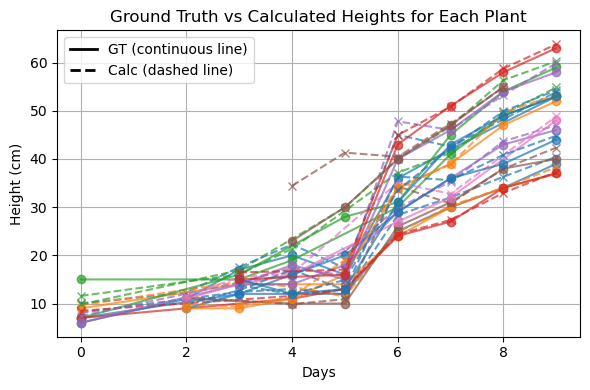

In [111]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_heights_for_each_plant():
    # Get the unique combinations of row and plant_number
    plants = merged_data[['row', 'plant_number']].drop_duplicates()
    
    # Generate a list of unique colors, one for each plant
    colors = plt.cm.get_cmap('tab10', len(plants))  # Use the 'tab10' colormap for different colors

    plt.figure(figsize=(6, 4))  # Set the figure size

    for index, plant in plants.iterrows():
        row = plant['row']
        plant_number = plant['plant_number']
        
        # Filter the data for the current plant
        plant_data = merged_data[(merged_data['row'] == row) & (merged_data['plant_number'] == plant_number)]
        
        # Get the color for this plant
        color = colors(index % 10)  # Cycle through colors if there are more than 10 plants
        
        # Plot ground truth heights in the same color (solid line)
        plt.plot(plant_data['days'], plant_data['height_gt'], color=color, marker='o', linestyle='-', alpha=0.7)
        
        # Plot calculated heights in the same color (dashed line)
        plt.plot(plant_data['days'], plant_data['height_calc'], color=color, marker='x', linestyle='--', alpha=0.7)
    
    # Create custom legend elements
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label='GT (continuous line)'),
        Line2D([0], [0], color='black', lw=2, linestyle='--', label='Calc (dashed line)')
    ]
    
    # Add the custom legend to the plot
    plt.legend(handles=legend_elements, loc='upper left')

    # Customize the plot
    plt.title('Ground Truth vs Calculated Heights for Each Plant')
    plt.xlabel('Days')
    plt.ylabel('Height (cm)')
    plt.grid(True)
    
    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function to plot the heights
plot_heights_for_each_plant()


In [112]:
# Filter the data for day 4 and day 5
day_4_data = merged_data[merged_data['days'] == 4]
day_5_data = merged_data[merged_data['days'] == 5]

# Find the row with the highest height_calc on day 4
max_height_row_day_4 = day_4_data.loc[day_4_data['height_calc'].idxmax()]

# Find the row with the highest height_calc on day 5
max_height_row_day_5 = day_5_data.loc[day_5_data['height_calc'].idxmax()]

# Print the row and plant_number for day 4 and day 5
print(f"Highest height_calc on Day 4: {max_height_row_day_4['height_calc']} cm, Row: {max_height_row_day_4['row']}, Plant: {int(max_height_row_day_4['plant_number'])}")
print(f"Highest height_calc on Day 5: {max_height_row_day_5['height_calc']} cm, Row: {max_height_row_day_5['row']}, Plant: {int(max_height_row_day_5['plant_number'])}")


Highest height_calc on Day 4: 34.42163 cm, Row: C, Plant: 5
Highest height_calc on Day 5: 41.31563 cm, Row: C, Plant: 5


/var/folders/sf/4g8qf_rx2ngb3zl4xjkn4r2c0000gn/T/ipykernel_1227/3763264751.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(plants))  # Use the 'tab10' colormap for different colors


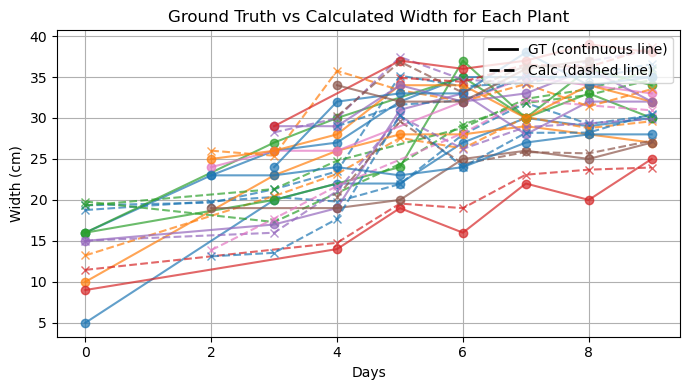

In [113]:
import matplotlib.pyplot as plt

def remove_outliers_iqr(data, column_name):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the outliers
    filtered_data = data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]
    
    return filtered_data

def plot_widths_for_each_plant():
    # Get the unique combinations of row and plant_number
    plants = merged_data[['row', 'plant_number']].drop_duplicates()
    
    # Generate a list of unique colors, one for each plant
    colors = plt.cm.get_cmap('tab10', len(plants))  # Use the 'tab10' colormap for different colors
    
    plt.figure(figsize=(7, 4))  # Set the figure size

    for index, plant in plants.iterrows():
        row = plant['row']
        plant_number = plant['plant_number']
        
        # Filter the data for the current plant
        plant_data = merged_data[(merged_data['row'] == row) & (merged_data['plant_number'] == plant_number)]
        
        # Remove outliers from the calculated width using the IQR method
        plant_data_no_outliers = remove_outliers_iqr(plant_data, 'width_calc')
        
        # Get the color for this plant
        color = colors(index % 10)  # Cycle through colors if there are more than 10 plants
        
        # Plot ground truth widths in the same color (solid line)
        plt.plot(plant_data['days'], plant_data['width_gt'], color=color, marker='o', linestyle='-', alpha=0.7)
        
        # Plot calculated widths in the same color (dashed line)
        plt.plot(plant_data_no_outliers['days'], plant_data_no_outliers['width_calc'], color=color, marker='x', linestyle='--', alpha=0.7)
    
    # Create custom legend elements
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label='GT (continuous line)'),
        Line2D([0], [0], color='black', lw=2, linestyle='--', label='Calc (dashed line)')
    ]
    
    # Add the custom legend to the plot
    plt.legend(handles=legend_elements, loc='upper right')

    # Customize the plot
    plt.title('Ground Truth vs Calculated Width for Each Plant')
    plt.xlabel('Days')
    plt.ylabel('Width (cm)')
    plt.grid(True)
    
    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


# Call the function to plot the widths
plot_widths_for_each_plant()


In [114]:
# Normalize the Volume (cm^3) data
calc_data['Normalized_Volume'] = calc_data['volume (cm^3)'] / calc_data['volume (cm^3)'].iloc[0]

# Print the first few rows to verify
print(calc_data[['date', 'volume (cm^3)', 'Normalized_Volume']].head())


        date  volume (cm^3)  Normalized_Volume
0 2024-08-01           95.7           1.000000
1 2024-08-01          107.7           1.125392
2 2024-08-01           69.1           0.722048
3 2024-07-30          163.5           1.708464
4 2024-08-01          161.0           1.682341


In [115]:
Plant_C_3 = Plant_C_3.copy()

if pd.isna(Plant_C_3['height'].iloc[0]):
    Plant_C_3.loc[Plant_C_3.index[0], 'height'] = 8.0  # Replace '10' with your desired value

# Normalize the Height data
Plant_C_3['Normalized_Height'] = Plant_C_3['height'] / Plant_C_3['height'].iloc[0]

# Print the first few rows to verify
print(Plant_C_3[['date', 'height', 'Normalized_Height']].head())

         date  height  Normalized_Height
12 2024-07-30     8.0              1.000
27 2024-07-31     9.0              1.125
42 2024-08-01     9.0              1.125
57 2024-08-02     9.0              1.125
72 2024-08-03    11.0              1.375


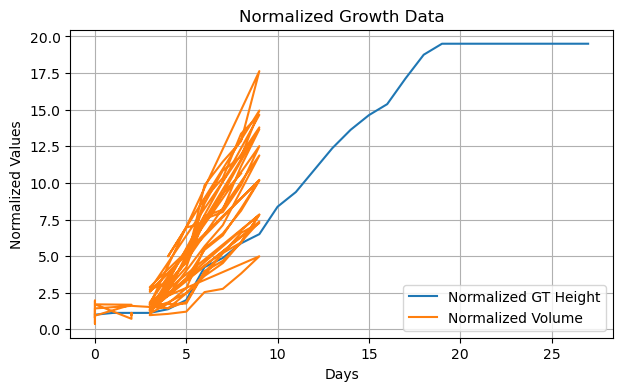

In [116]:
# Calculate the number of days since the first date for both datasets
Plant_C_3['Days'] = (Plant_C_3['date'] - Plant_C_3['date'].min()).dt.days
calc_data['Days'] = (calc_data['date'] - calc_data['date'].min()).dt.days

# Plot the normalized data using 'Days' instead of 'Date'
plt.figure(figsize=(7, 4))
plt.plot(Plant_C_3['Days'], Plant_C_3['Normalized_Height'], label='Normalized GT Height')
plt.plot(calc_data['Days'], calc_data['Normalized_Volume'], label='Normalized Volume')
plt.xlabel('Days')
plt.ylabel('Normalized Values')
plt.title('Normalized Growth Data')
plt.legend()
plt.grid()
plt.show()
